## we will use the library PyOD for anomaly detection

In [3]:
import numpy as np
from scipy import stats 
import matplotlib.pyplot as plt
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.cblof import CBLOF
from pyod.models.hbos import HBOS
from pyod.models.ocsvm import OCSVM
from pyod.utils.data import generate_data , get_outliers_inliers
from pyod.utils.data import evaluate_print


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [4]:
%matplotlib inline
import matplotlib.font_manager
state=42

## we will generate then use random data 

In [5]:
#lets generate random data with two features 
X_train,Y_train = generate_data(n_train=2000 , train_only=True , n_features=2 , random_state=state)

In [6]:
#setting outlier fraction = 0.1
outlier_fraction=0.1

In [7]:
x_outliers , x_inliers = get_outliers_inliers(X_train,Y_train)

In [8]:
n_inliers = len(x_inliers)
n_outliers = len(x_outliers)

In [9]:
#lets seperate the two features 
F1 = X_train[:,[0]].reshape(-1,1)
F2=X_train[:,[1]].reshape(-1,1)

In [10]:
xx , yy = np.meshgrid(np.linspace(-10,10,200) , np.linspace(-10,10,200))

Text(0, 0.5, 'F2')

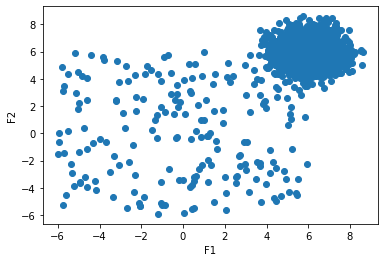

In [11]:
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2')

## we will try 6 models with default parameters and implement them 

In [12]:
models = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),

     'Isolation Forest': IForest(contamination=outlier_fraction,random_state=state),

     'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outlier_fraction,check_estimator=False, random_state=state),

     'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outlier_fraction),

     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction),
     
     "Support Vector Machine":OCSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05,max_iter=-1)
}

No of Errors :  Angle-based Outlier Detector (ABOD) 48
No of Errors :  Isolation Forest 36
No of Errors :  Cluster-based Local Outlier Factor (CBLOF) 18
No of Errors :  Histogram-base Outlier Detection (HBOS) 45
No of Errors :  K Nearest Neighbors (KNN) 19
No of Errors :  Support Vector Machine 94


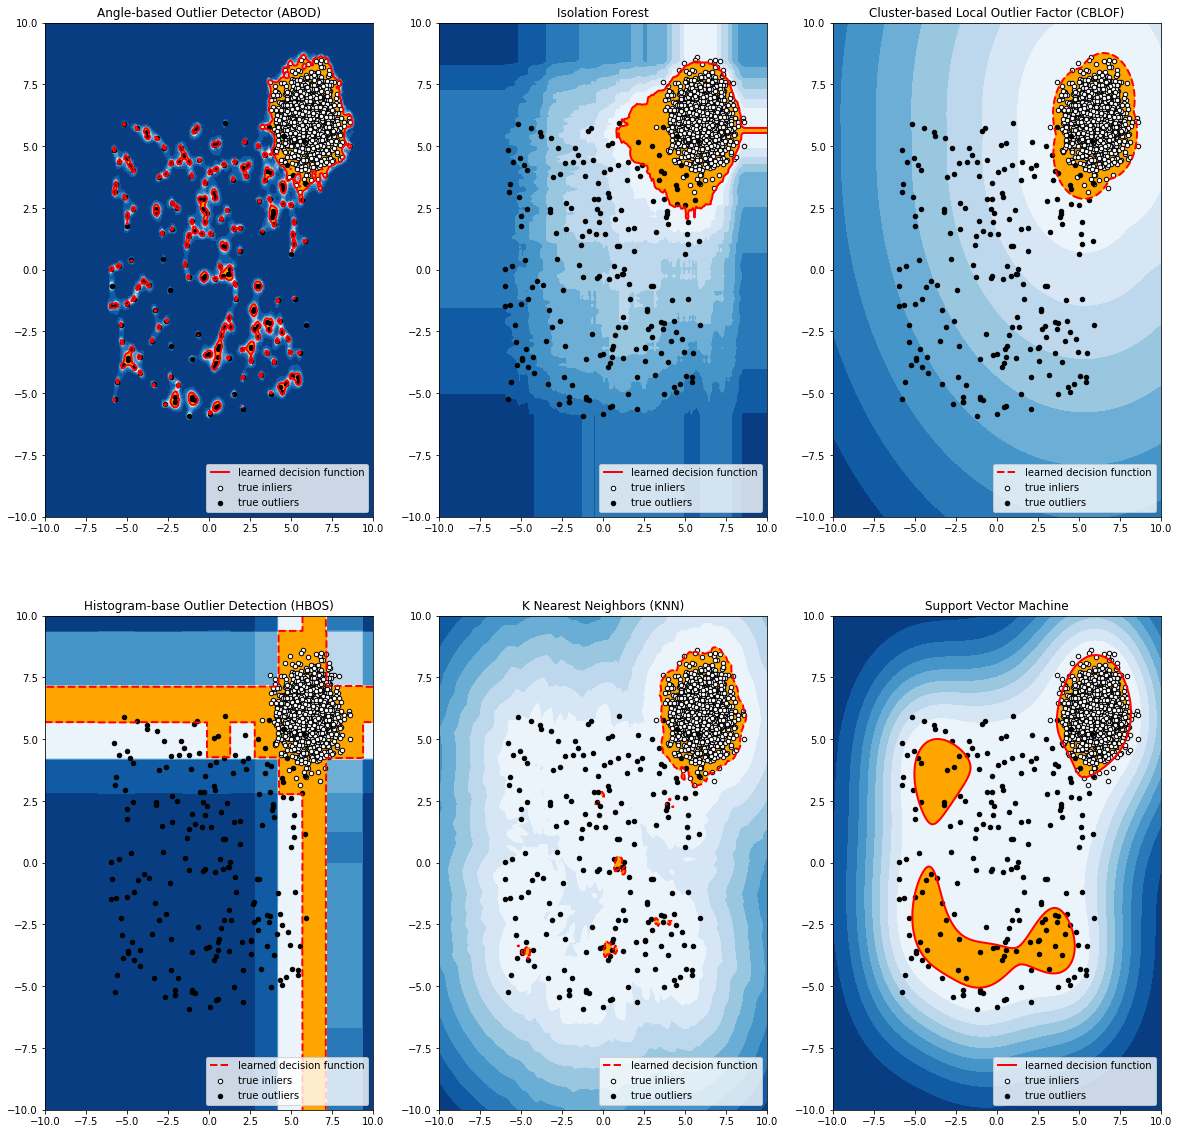

In [13]:
#set the figure size
plt.figure(figsize=(20, 20))

for i, (model_name,model) in enumerate(models.items()) :
    # fit the dataset to the model
    model.fit(X_train)

    # predict raw anomaly score
    scores_pred = model.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = model.predict(X_train)

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()
    print('No of Errors : ',model_name, n_errors)

    # rest of the code is to create the visualization

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    # decision function calculates the raw anomaly score for every point
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)

    subplot = plt.subplot(2, 3, i + 1)

    # fill blue colormap from minimum anomaly score to threshold value
    subplot.contourf(xx, yy, Z, levels = np.linspace(Z.min(), threshold, 10),cmap=plt.cm.Blues_r)

    # draw red contour line where anomaly score is equal to threshold
    a = subplot.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')

    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')

    # scatter plot of inliers with white dots
    b = subplot.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    c = subplot.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')

    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')

    subplot.set_title(model_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 

## Evaluation : 

In [14]:
from pyod.utils.data import evaluate_print
for i, (model_name,model) in enumerate(models.items()) :
    # fit the dataset to the model
    model.fit(X_train)

    # predict raw anomaly score
    scores_pred = model.decision_function(X_train)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred = model.predict(X_train)
    y_train_scores = model.decision_scores_

    # no of errors in prediction
    n_errors = (y_pred != Y_train).sum()

    print('N° of Errors using {} : {} '.format(model_name, n_errors))
    
    evaluate_print(model_name, Y_train, y_train_scores)
    print("\n")

No of Errors using Angle-based Outlier Detector (ABOD) : 48 
Angle-based Outlier Detector (ABOD) ROC:0.9897, precision @ rank n:0.89


No of Errors using Isolation Forest : 36 
Isolation Forest ROC:0.9934, precision @ rank n:0.91


No of Errors using Cluster-based Local Outlier Factor (CBLOF) : 18 
Cluster-based Local Outlier Factor (CBLOF) ROC:0.995, precision @ rank n:0.955


No of Errors using Histogram-base Outlier Detection (HBOS) : 45 
Histogram-base Outlier Detection (HBOS) ROC:0.9899, precision @ rank n:0.8894


No of Errors using K Nearest Neighbors (KNN) : 19 
K Nearest Neighbors (KNN) ROC:0.9967, precision @ rank n:0.96


No of Errors using Support Vector Machine : 94 
Support Vector Machine ROC:0.9797, precision @ rank n:0.765


